In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import periodogram, stft, firwin, welch, correlate
import scipy.io

from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum

from sklearn.cross_decomposition import CCA

In [2]:
data = scipy.io.loadmat('s4.mat')['train'][:, :9, :, :] #Discard non-EEG channels (9+)
num_targets, num_channels, N, num_trials = data.shape
fs = 256
T_pre, T, T_post = 0.290, 4.000, 0.062

print(f"Classes:           {num_targets}")
print(f"EEG Channels:      {num_channels}")
print(f"Time Samples:      {N}")
print(f"Trials per Class:  {num_trials}")

Classes:           12
EEG Channels:      9
Time Samples:      1114
Trials per Class:  15


In [17]:
import glob  ### reads directory to get file names
import re  ### easier to extract file names

### dictionary which's keys are file number to access python version of matlab data
        ### values are tuples. 0th is string location of file and 1st is converted matlab data
mats = dict()

### holds the string locations if ever needed to get back
mat_locations = glob.glob('/Users/Shonak/Documents/GitHub/COGS118C/Assignments/Final/Data/*.mat')

### extracts the file names to better use as keys in the case files used are changing
names = re.findall(r'(?<=\\s)\d{1,2}(?=.mat)', ' '.join(mat_locations))

### loop populates mats dictionary
for index in range(len(mat_locations)):
    mats[int(names[index])] = (mat_locations[index], scipy.io.loadmat(mat_locations[index]))

In [23]:
training = [mats[i][1]['train'] for i in sorted(mats.keys())]

(-25, 25)

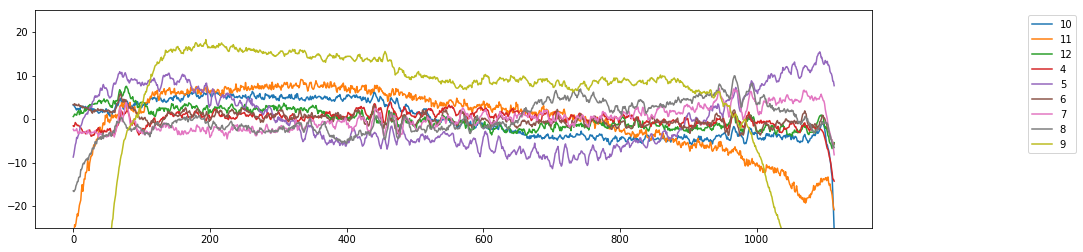

In [42]:
plt.figure(figsize=(15, 4))
for i in range(len(training)):
    plt.plot(training[i].mean(axis=(0, 1, 3)) - training[i].mean(axis=(0,1,3)).mean(), label=str(list(mats.keys())[i]))
plt.legend(bbox_to_anchor=(0.6, 0.5, 0.5, 0.5))
plt.ylim(-25, 25)

In [45]:
def my_hilbert(signal):
    FT =  np.fft.fft(signal)# compute fft
    freqs =  np.fft.fftfreq(len(FT),1/fs)# compute frequency axis
    FT[np.where(freqs<0)]=0. # zero out negative frequencies, use np.where()
    return  2*np.fft.ifft(FT)

def compute_power_phase(x_a):
    # _FILL_IN_YOUR_CODE_HERE
    power = np.abs(x_a)**2
    phase = np.angle(x_a)
    return power,phase

cutoff= (9,15)
FIR = signal.firwin(769,cutoff, fs=fs, pass_zero = False)
osc = np.convolve(signal, FIR,mode='same')
x_a = my_hilbert(osc)

power, phase = compute_power_phase(x_a)

plt.figure(figsize=(15,12))
# plot the signal and the filtered signal
plt.subplot(4,1,1)
plt.plot(t, signal, label='Orig')
plt.plot(t, osc, label='New')
plt.xlim([0,2]); plt.legend()
plt.xlabel('Time'); plt.ylabel('Voltage')

In [3]:
ch = 2
target = 0

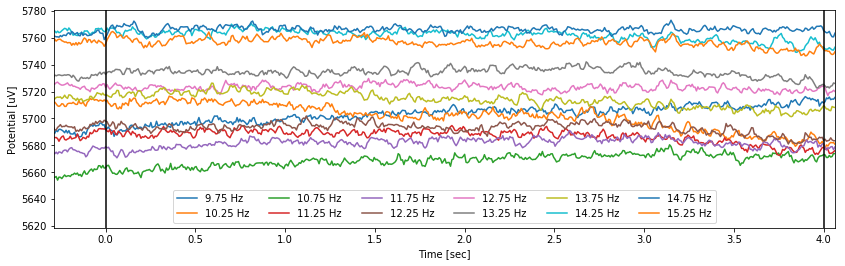

In [4]:
epoch_avgs = data.mean(axis=3)
t = [x/fs for x in range(-74, -74+N)]

plt.figure(figsize=(14, 4))
for ix, freq in enumerate([9.75 + 0.5 * x for x in range(num_targets)]):
    plt.plot(t, epoch_avgs[ix, ch, :], label=f"{freq} Hz")
plt.xlim(-T_pre, T + T_post)
plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]");
plt.legend(loc='lower center', ncol=6)
plt.axvline(x=0, color='black');
plt.axvline(x=T, color='black');

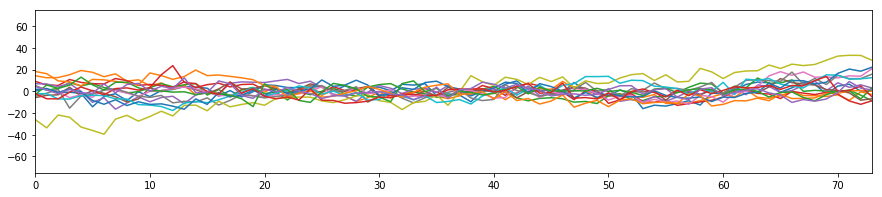

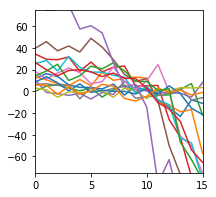

In [5]:
epochs = data[target, ch, :, :]
baselines = epochs[:74, :]
trials    = epochs[74:-16]
ends      = epochs[-16:]

plt.figure(figsize=(15, 3))
plt.plot(baselines - baselines.mean(axis=0))
plt.xlim(0, 73); plt.ylim(-75, 75);

plt.figure(figsize=(3, 3))
plt.plot(ends - ends.mean(axis=0))
plt.xlim(0, 15); plt.ylim(-75, 75);

In [6]:
def xcorr(data1, data2, maxlag=100, zero_center=False):
    acf = np.zeros(maxlag)
    acf[0] = np.correlate(data1,data2)
    for lag in range(1,maxlag):
        acf[lag] = np.correlate(data1[:-lag],data2[lag:])
    
    acf /= acf[0]
    if zero_center: acf[0]=np.nan
    return acf

'''
def corr(x):
    x_corrected = x - x.mean()
    scale = x_corrected @ x_corrected
    x_corrected /= np.sqrt(scale)
    
    print(np.append(x_corrected, 0) @ np.insert(0, x_corrected))

corr(epochs[:, 0])    
'''

#plt.plot(epochs[:, 1])
#plt.figure()
#plt.plot(xcorr(epochs[:, 0], epochs[:,0]))

'\ndef corr(x):\n    x_corrected = x - x.mean()\n    scale = x_corrected @ x_corrected\n    x_corrected /= np.sqrt(scale)\n    \n    print(np.append(x_corrected, 0) @ np.insert(0, x_corrected))\n\ncorr(epochs[:, 0])    \n'

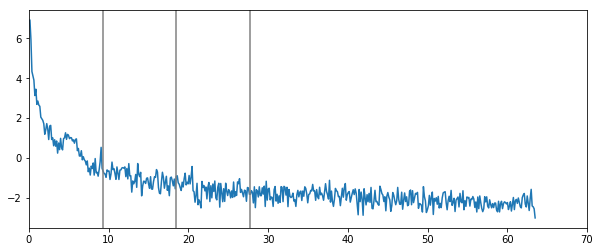

In [7]:
plt.figure(figsize=(10, 4))
plt.xlim(0, 70)

#f_baseline, Pxx_baselines = periodogram(baselines, fs=256, axis=0)
#plt.plot(f_baseline[1:], np.log(Pxx_baselines[1:]).mean(axis=1))

f_trial, Pxx_trials = periodogram(trials, fs=fs, axis=0)
plt.plot(f_trial[1:], np.log(Pxx_trials[1:]).mean(axis=1));

h = 9.25 + 0.5 * target
plt.axvline(x=h, color='gray')
plt.axvline(x=h*2, color='gray')
plt.axvline(x=h*3, color='gray');

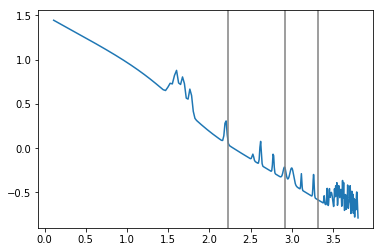

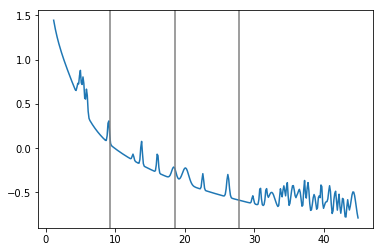

In [8]:
df = f_trial[1] - f_trial[0]
power_model = FOOOF(peak_width_limits=[2*df, 20], verbose=False)
power_model.fit(f_trial, Pxx_trials.mean(axis=1), freq_range=[1, 45])

plt.plot(np.log(power_model.freqs), power_model.fooofed_spectrum_);
plt.axvline(x=np.log(h), color='gray')
plt.axvline(x=np.log(h*2), color='gray')
plt.axvline(x=np.log(h*3), color='gray');

plt.figure()
plt.plot(power_model.freqs, power_model.fooofed_spectrum_);
plt.axvline(x=h, color='gray')
plt.axvline(x=h*2, color='gray')
plt.axvline(x=h*3, color='gray');

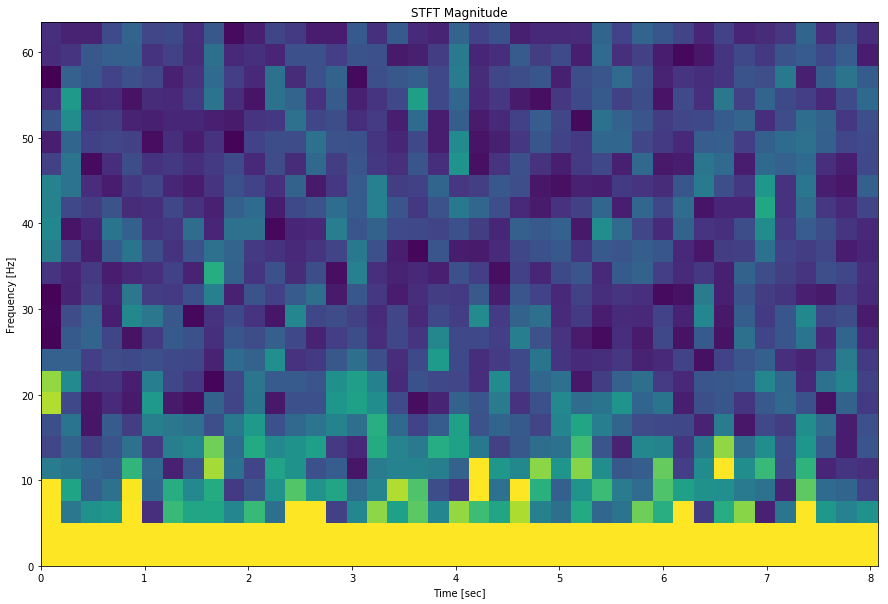

In [9]:
f_stft, t_stft, Zxx = stft(trials, fs, nperseg=50, axis=0, boundary='even')

amp = 2 * np.sqrt(2)
plt.figure(figsize=(15, 10))
plt.pcolormesh(t_stft, f_stft, np.abs(Zxx[:, 0, :]), vmin=0, vmax=amp) #Zxx.mean(axis=1)
plt.title('STFT Magnitude')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]');

from muselsl import record

import os
filepath = os.path.join(os.getcwd(), '12hz.csv')

record(10, filepath)

d = [
    'test.csv',
    '9hz.csv',
    '12hz.csv',
    'EEG_recording_2019-07-28-17.52.06.csv',
    'EEG_recording_2019-07-28-19.31.57.csv',
    'EEG_recording_2019-07-28-21.00.42.csv'
]
data = pd.read_csv(d[0])
data.timestamps -= data.timestamps[0]

channels = ['AF7', 'AF8', 'TP9', 'TP10']

aux_mean = data['Right AUX'].mean()
data[channels] -= aux_mean

N = data.shape[0]
T = data.timestamps[N-1]
fs = N / T
print(f"Total samples: {N}")
print(f"Sampling rate: {fs} Hz")

fig, axes = plt.subplots(len(channels), figsize=(15, 3 * len(channels)))
fig.subplots_adjust(hspace=0.6)
for ax, ch in zip(axes, channels):
    ax.set_xlim(0, T)
    ax.title.set_text(f"Channel {ch}")
    ax.plot(data.timestamps, data[ch])

channel = data[channels[3]]

f_pow, Pxx_pow = periodogram(channel, fs=fs, window='hann')
plt.figure(figsize=(8, 4))
plt.plot(f_pow, np.log(Pxx_pow), '.')
plt.xlim(0, fs / 2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power');

cutoff = (59.6, 60.4)
filt_order = 801
filt_coefs = firwin(filt_order, cutoff, fs=fs, pass_zero=True)

plt.figure(figsize=(15, 3))
channel_filt = np.convolve(channel, filt_coefs, mode='same')

plt.plot(channel)
plt.plot(channel_filt)
plt.xlim(0, 100)
plt.ylim(-50, 50)

f, Pxx = periodogram(channel_filt, fs=fs, window='hann')
plt.figure(figsize=(8, 4))
plt.plot(f, np.log(Pxx), '.')
plt.xlim(0, fs / 2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power');

f, Pxx = welch(channel_filt, fs=fs, window='hann')
plt.figure(figsize=(8, 4))
plt.plot(f, np.log(Pxx), '.')
plt.xlim(0, fs / 2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power');

f_stft, t_stft, Zxx = stft(channel_filt, fs, window='hann', nperseg=200)

amp = 2 * np.sqrt(2)
plt.figure(figsize=(15, 10))
plt.pcolormesh(t_stft, f_stft, np.abs(Zxx), vmin=0, vmax=amp)
plt.title('STFT Magnitude')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]');

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
k = 10
f_smooth, P_smooth = periodogram(data['TP10'], fs)
f_smooth = f_smooth[k-1:]
P_smooth = moving_average(P_smooth, k)

plt.figure(figsize=(10, 4))
plt.plot(f_smooth, np.log(P_smooth), '-')
plt.xlim(0, 65)
plt.ylim(-10, 4)

In [ ]:
from fooof import FOOOF

#spectra = np.array([periodogram(data[ch], fs, 'hann')[1] for ch in ['AF7', 'AF8', 'TP9', 'TP10']])
#model = FOOOFGroup(peak_width_limits=[0.2, 8.0], max_n_peaks=8, verbose=False)
#model.fit(f_pow, spectra, freq_range=[3, 45])
#model.get_results()[3].peak_params

hzs = [20, 30, 40]

#model = FOOOF(peak_width_limits=[0.5, 3.0], max_n_peaks=12)
model = FOOOF()

f_TP10, P_TP10 = periodogram(data['TP10'], fs)
model.fit(f_TP10, P_TP10, freq_range=[3, 55])

params = model.get_results().peak_params
ixs = [np.argmax( -np.abs(params[:, 0] - hz) ) for hz in hzs]

print(params[ixs])
print(hzs[np.argmax( params[ixs][:, 1] )])

model.report()